In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [10]:
def aggregating_algorithm(
    gammas: np.ndarray,
    omegas: np.ndarray,
    eta: float = 2.0,
    C_eta: float = 1.0,
    weights: np.ndarray = None,
) -> tuple[np.ndarray, np.ndarray]:
    """
    Calculates predictions produced by the Aggregating Algorithm w/ Specialist Experts (AAS) using the square-loss (Brier's) game.

    Parameters:
    - gammas (np.array): a matrix of predictions, where each row is a sequence of experts' predicitons for that time step
    - omegas (np.array): an array of observed outcomes
    - eta (float): a learning rate to control how quickly the algorithm updates an expert's weight
    - C_eta (float): a scale parameter associated with \eta to control the aggressiveness of weight updates
    - weights (np.array): an array of initial weights for each expert

    Returns:
    - cumulative_experts_losses (np.array): a matrix of losses, where each column is the cumulative loss of an expert at each time step
    - cumulative_learner_losses (np.array): an array of the learner's cumulative loss at each time step
    """
    N, T = gammas.T.shape

    experts_losses = np.array([np.zeros(N)])
    learner_loss = np.zeros(T)
    cumulative_experts_losses = np.array([np.zeros(N)])
    cumulative_learner_loss = np.zeros(T + 1)

    # Step 1: Initialise weights, w^i_0 = q_i, i = 1, 2, ..., N
    if not weights:
        weights = np.ones(N) / N

    # Step 2: Repeat for t \in T...
    for t in range(T):
        # Step 3: Read the experts' predictions \gamma^n_t of awake experts
        gammas_t = gammas[t, :]

        # Maintain a list of awake experts
        awake_experts = ~np.isnan(gammas_t)

        # If there are no awake experts for a timestep, skip the iteration
        if not any(awake_experts):
            continue

        # Step 4: Normalise the weights of awake experts
        normalised_weights = weights[awake_experts] / np.sum(weights[awake_experts])

        # Step 5: Solve the system (\omega \in \Omega)
        generalised_prediction = -(C_eta / eta) * np.log(
            np.sum(
                normalised_weights
                * np.exp(
                    -eta
                    * np.array(
                        [
                            (omega_t - gamma_t) ** 2
                            for omega_t in [0, 1]
                            for gamma_t in gammas_t[awake_experts]
                        ]
                    ).reshape(2, np.sum(awake_experts))
                ),
                axis=1,
            )
        )

        # Calculate the learner's prediction
        gamma_t = (1 / 2) - (
            (generalised_prediction[1] - generalised_prediction[0]) / 2
        )

        # Step 6: Observe the outcome \omega_t
        omega_t = omegas[t]

        # Calculate the awake experts' losses
        awake_losses = np.array(
            [(omega_t - gamma_t) ** 2 for gamma_t in gammas_t[awake_experts]]
        )

        # Calculate the learner's and asleep experts' loss
        loss = (omega_t - gamma_t) ** 2
        losses = np.full(awake_experts.shape, loss)
        losses[awake_experts] = awake_losses

        experts_losses = np.vstack((experts_losses, losses))
        learner_loss[t] = loss
        cumulative_experts_losses = np.cumsum(experts_losses, axis=0)
        cumulative_learner_loss[t + 1] = cumulative_learner_loss[t] + learner_loss[t]

        # Step 7: Update the awake experts' weights w^n_t = w^n_{t-1} e^{-\eta \lambda(\gamma^n_t, \omega)}
        weights[awake_experts] *= np.exp(-eta * losses[awake_experts])

        # Step 8: Update the sleeping experts' weights w^n_t = w^n_{t-1} e^{\frac{-\eta\lambda(\gamma_t, \omega)}{C(\eta)}}
        weights[~awake_experts] *= np.exp((-eta * losses[~awake_experts]) / C_eta)

        # Renormalise the updated experts' weights.
        weights = weights / np.sum(weights)

    return (cumulative_experts_losses, cumulative_learner_loss)

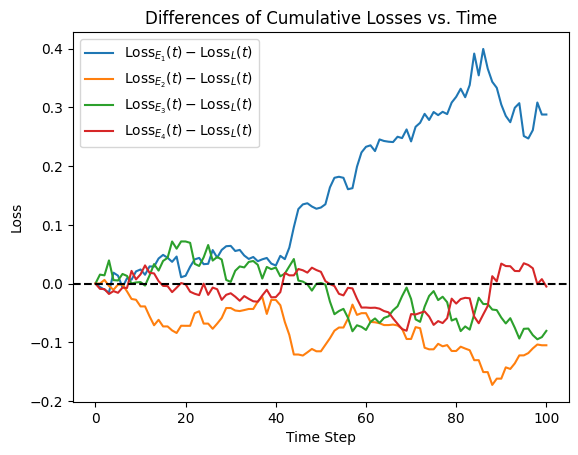

In [13]:
# Sleeping Expert Test
filename = "sleeping_expert_test.txt"

gammas = np.empty((0, 4), dtype=float)

with open(filename, "r") as file:
    for line in file:
        columns = line.strip().split()
        values = np.array([float(columns[i]) for i in range(3, len(columns), 2)])
        gammas = np.vstack((gammas, values))

omegas = np.ones(gammas.shape[0])

(cumulative_experts_losses, cumulative_learner_loss) = aggregating_algorithm(
    gammas, omegas
)

plt.plot(
    np.arange(len(gammas) + 1),
    cumulative_experts_losses[:, 0] - cumulative_learner_loss,
    label="$\\text{Loss}_{E_1}(t) - \\text{Loss}_L(t)$",
)
plt.plot(
    np.arange(len(gammas) + 1),
    cumulative_experts_losses[:, 1] - cumulative_learner_loss,
    label="$\\text{Loss}_{E_2}(t) - \\text{Loss}_L(t)$",
)
plt.plot(
    np.arange(len(gammas) + 1),
    cumulative_experts_losses[:, 2] - cumulative_learner_loss,
    label="$\\text{Loss}_{E_3}(t) - \\text{Loss}_L(t)$",
)
plt.plot(
    np.arange(len(gammas) + 1),
    cumulative_experts_losses[:, 3] - cumulative_learner_loss,
    label="$\\text{Loss}_{E_4}(t) - \\text{Loss}_L(t)$",
)
plt.axhline(y=0, color="black", linestyle="--")
plt.title("Differences of Cumulative Losses vs. Time")
plt.xlabel("Time Step")
plt.ylabel("Loss")
plt.legend()
plt.show()

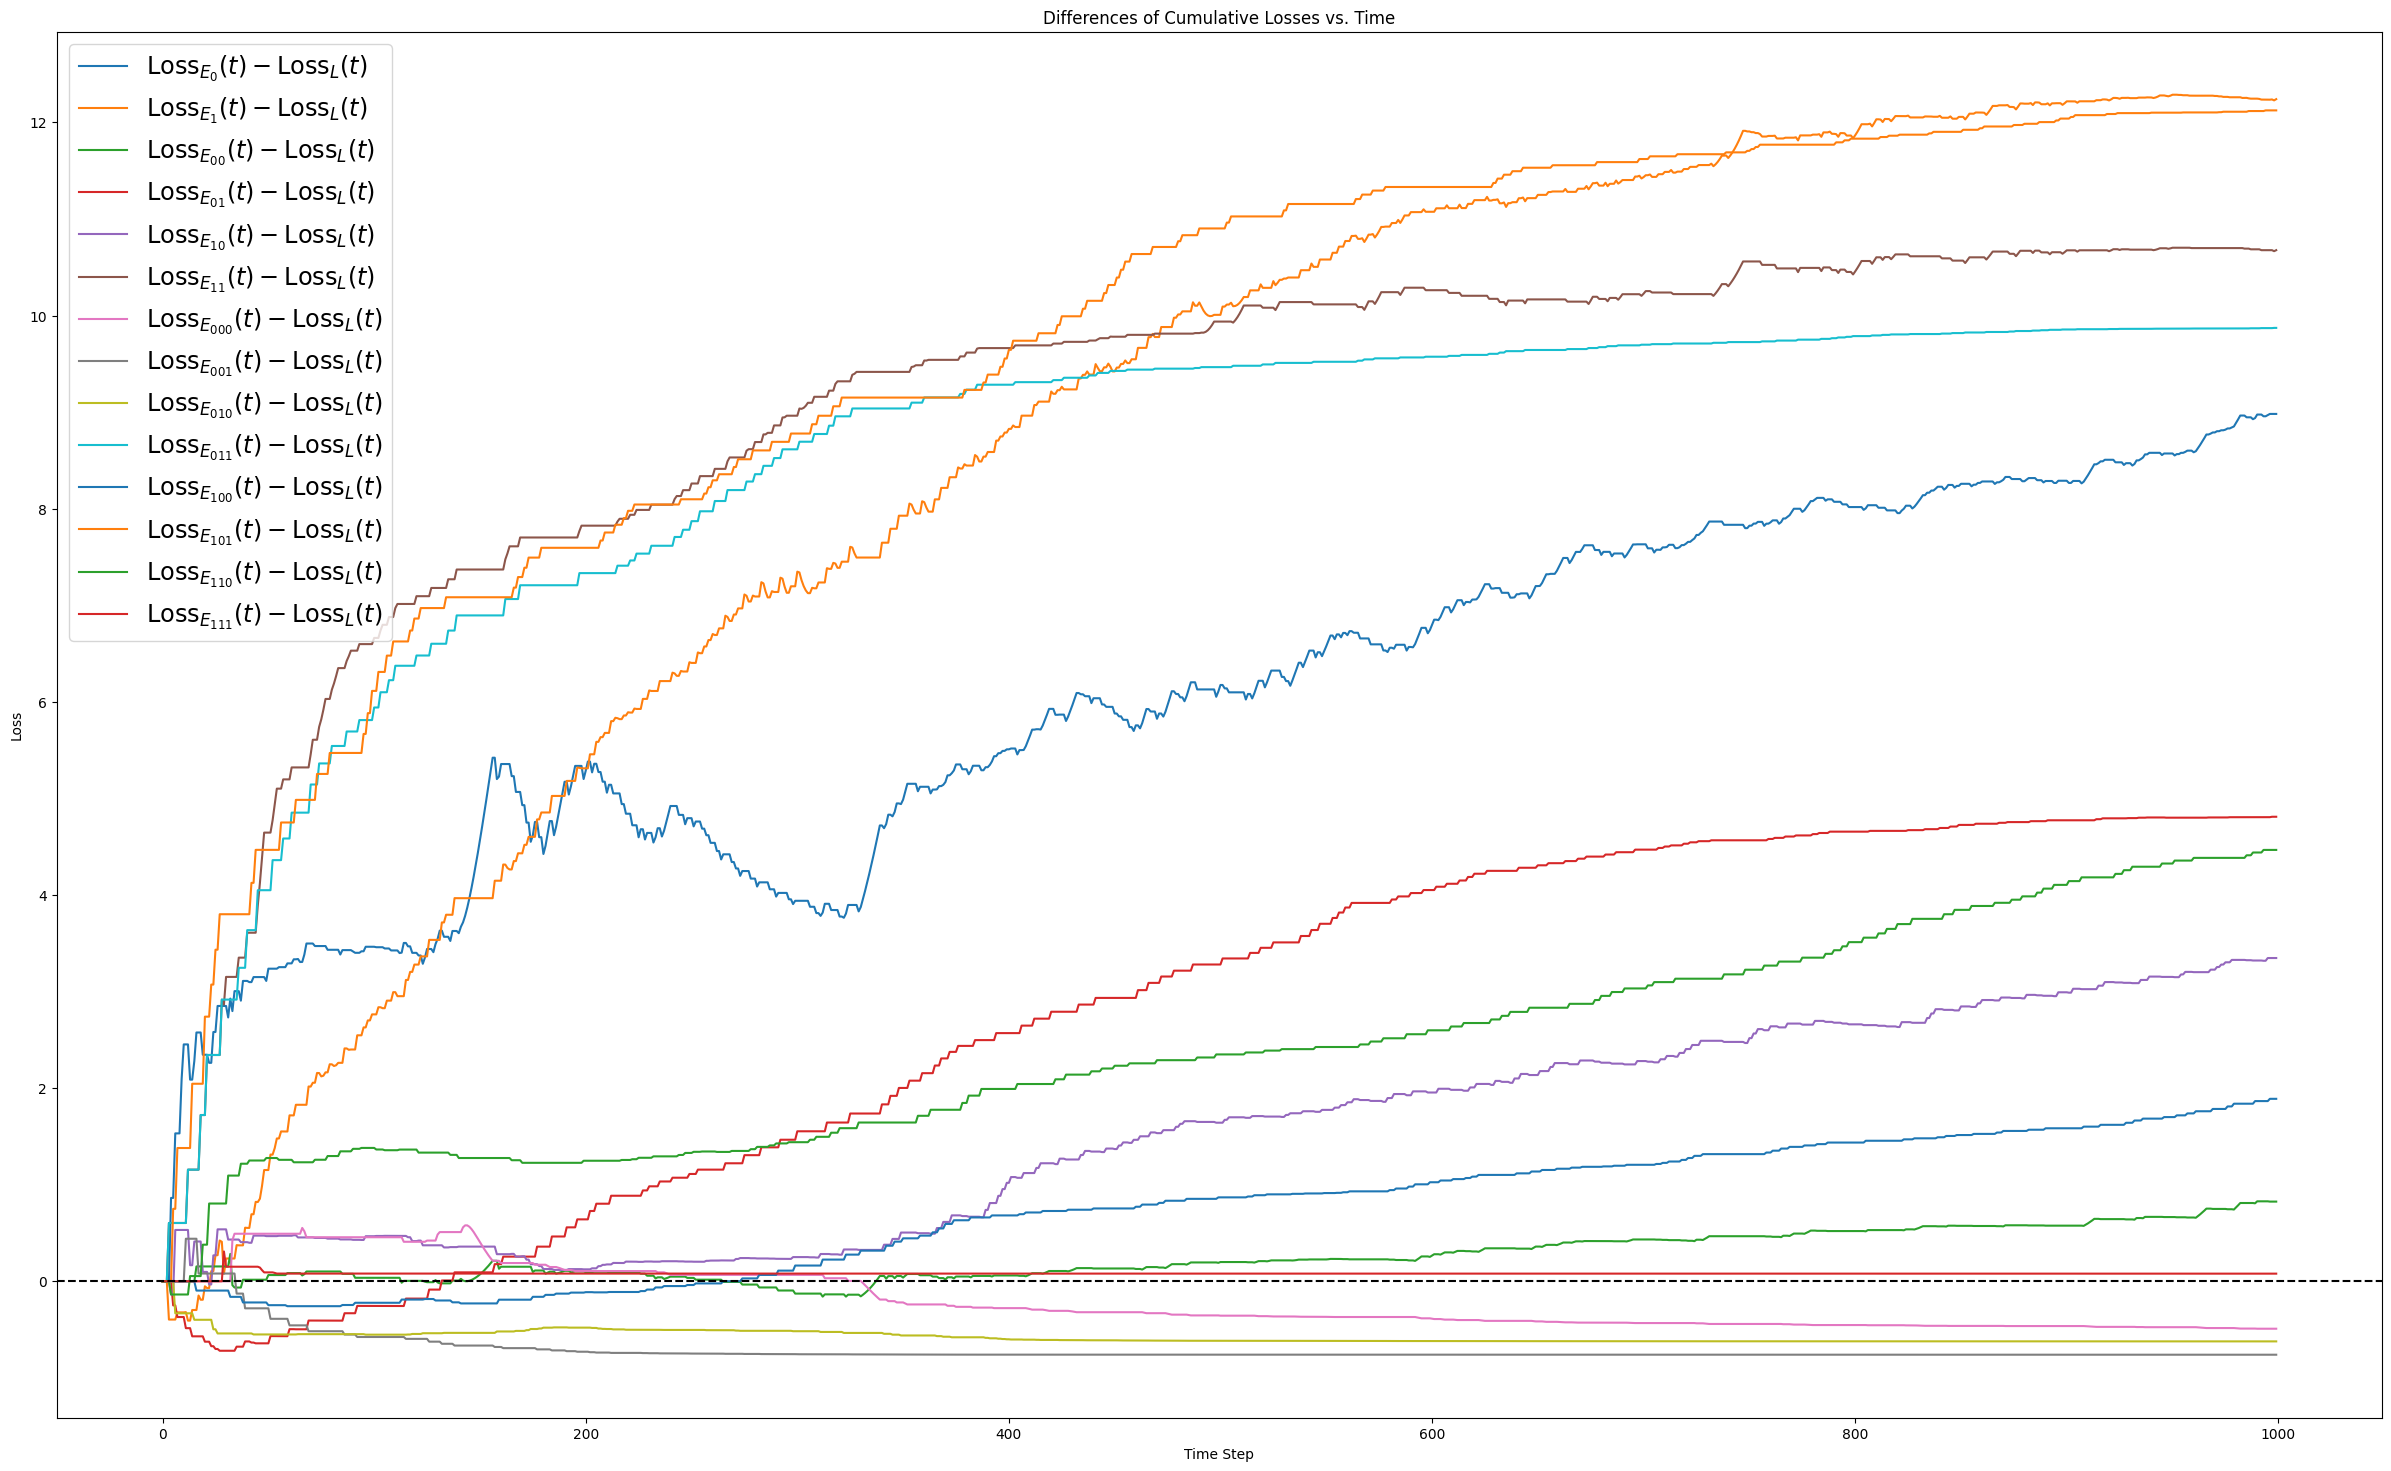

In [172]:
# Experiment #1 - Experts Make Predictions Based on Internal Trackers.

MAX_PREFIX_LENGTH = 2
TEST_SEQUENCE = "0110101000110100110110101011110000110011010111110011110110011010000011101111101111100111100110101011011101101110001010110100011000010110011000000000000000001000111101011010100010100001000000100001110001001010100101110101101100100110001000001110110011001101010110100111010100111011001111011001111010011111101101000110111010001111000000000001000100010000111100111100100100010001101100011101010001010101011001000001010000011010110000001010110011101011101010110100100001011001000001010100001101111111100010101111111001000011000011110101000001000011001000001001001001011011110111110100100111100100000110000100001100001100100100000110101101110100101110000100001010000011000010001111011001110011110000010111101100100100110100100100010000011111101111111110101010110010011000100001110000010011100110111011011111100011110111011110100011000000101010011000110010111100101011111001000110111101001110110011101011110101110000000100101111011100110001000101111100111100101001100000001001010100100000110110001101001110"


class Expert:
    """ """

    def __init__(self, prefix: str):
        self.prefix = prefix
        self.num_zeros = 0
        self.num_ones = 0

    def __str__(self):
        return f'Expert "{self.prefix}" - ({self.num_zeros}, {self.num_ones}) '

    def predict(self):
        # return "0" if self.num_zeros > self.num_ones else "1" # Simple Majority Prediction

        if self.num_zeros + self.num_ones == 0:
            return 0
        return self.num_ones / (self.num_zeros + self.num_ones)


def generate_experts(length: int):
    """
    Generate all binary strings up to a given length.

    Parameters:
    - length (int): the maximum length of a binary sequence.

    Returns:
    - list: a list of binary strings corresponding to experts.
    """

    def generate(prefix: str, length: int):
        if length == 0:
            return [Expert(prefix)]
        else:
            return generate(prefix + "0", length - 1) + generate(
                prefix + "1", length - 1
            )

    if length <= 0:
        return []
    else:
        return [
            string for length in range(1, length + 1) for string in generate("", length)
        ]


def get_awake_experts(sequence: str, experts: list[Expert]):
    awake_experts = [False] * len(experts)

    for i, expert in enumerate(experts):
        if sequence.endswith(expert.prefix):
            awake_experts[i] = True

    return awake_experts


experts = generate_experts(3)

omegas = np.array([int(bit) for bit in TEST_SEQUENCE])
gammas = np.empty((0, len(experts)), dtype=float)
for i in range(1, len(TEST_SEQUENCE)):
    substring = TEST_SEQUENCE[0:i]
    awake_experts = get_awake_experts(substring, experts)
    gammas_t = [float("nan")] * len(experts)
    for j, expert in enumerate(experts):
        if awake_experts[j]:
            gammas_t[j] = expert.predict()
            if TEST_SEQUENCE[i] == "0":
                expert.num_zeros += 1
            else:
                expert.num_ones += 1
    gammas = np.vstack((gammas, gammas_t))

(cumulative_experts_losses, cumulative_learner_loss) = aggregating_algorithm(
    gammas, omegas
)

plt.figure(figsize=(30, 18))
for i in range(len(cumulative_experts_losses[0])):
    plt.plot(
        np.arange(len(gammas) + 1),
        cumulative_experts_losses[:, i] - cumulative_learner_loss,
        label=f"$\\text{{Loss}}_{{E_{{{experts[i].prefix}}}}}(t) - \\text{{Loss}}_L(t)$",
    )
plt.axhline(y=0, color="black", linestyle="--")
plt.title("Differences of Cumulative Losses vs. Time")
plt.xlabel("Time Step")
plt.ylabel("Loss")
plt.legend(fontsize="xx-large")
plt.show()

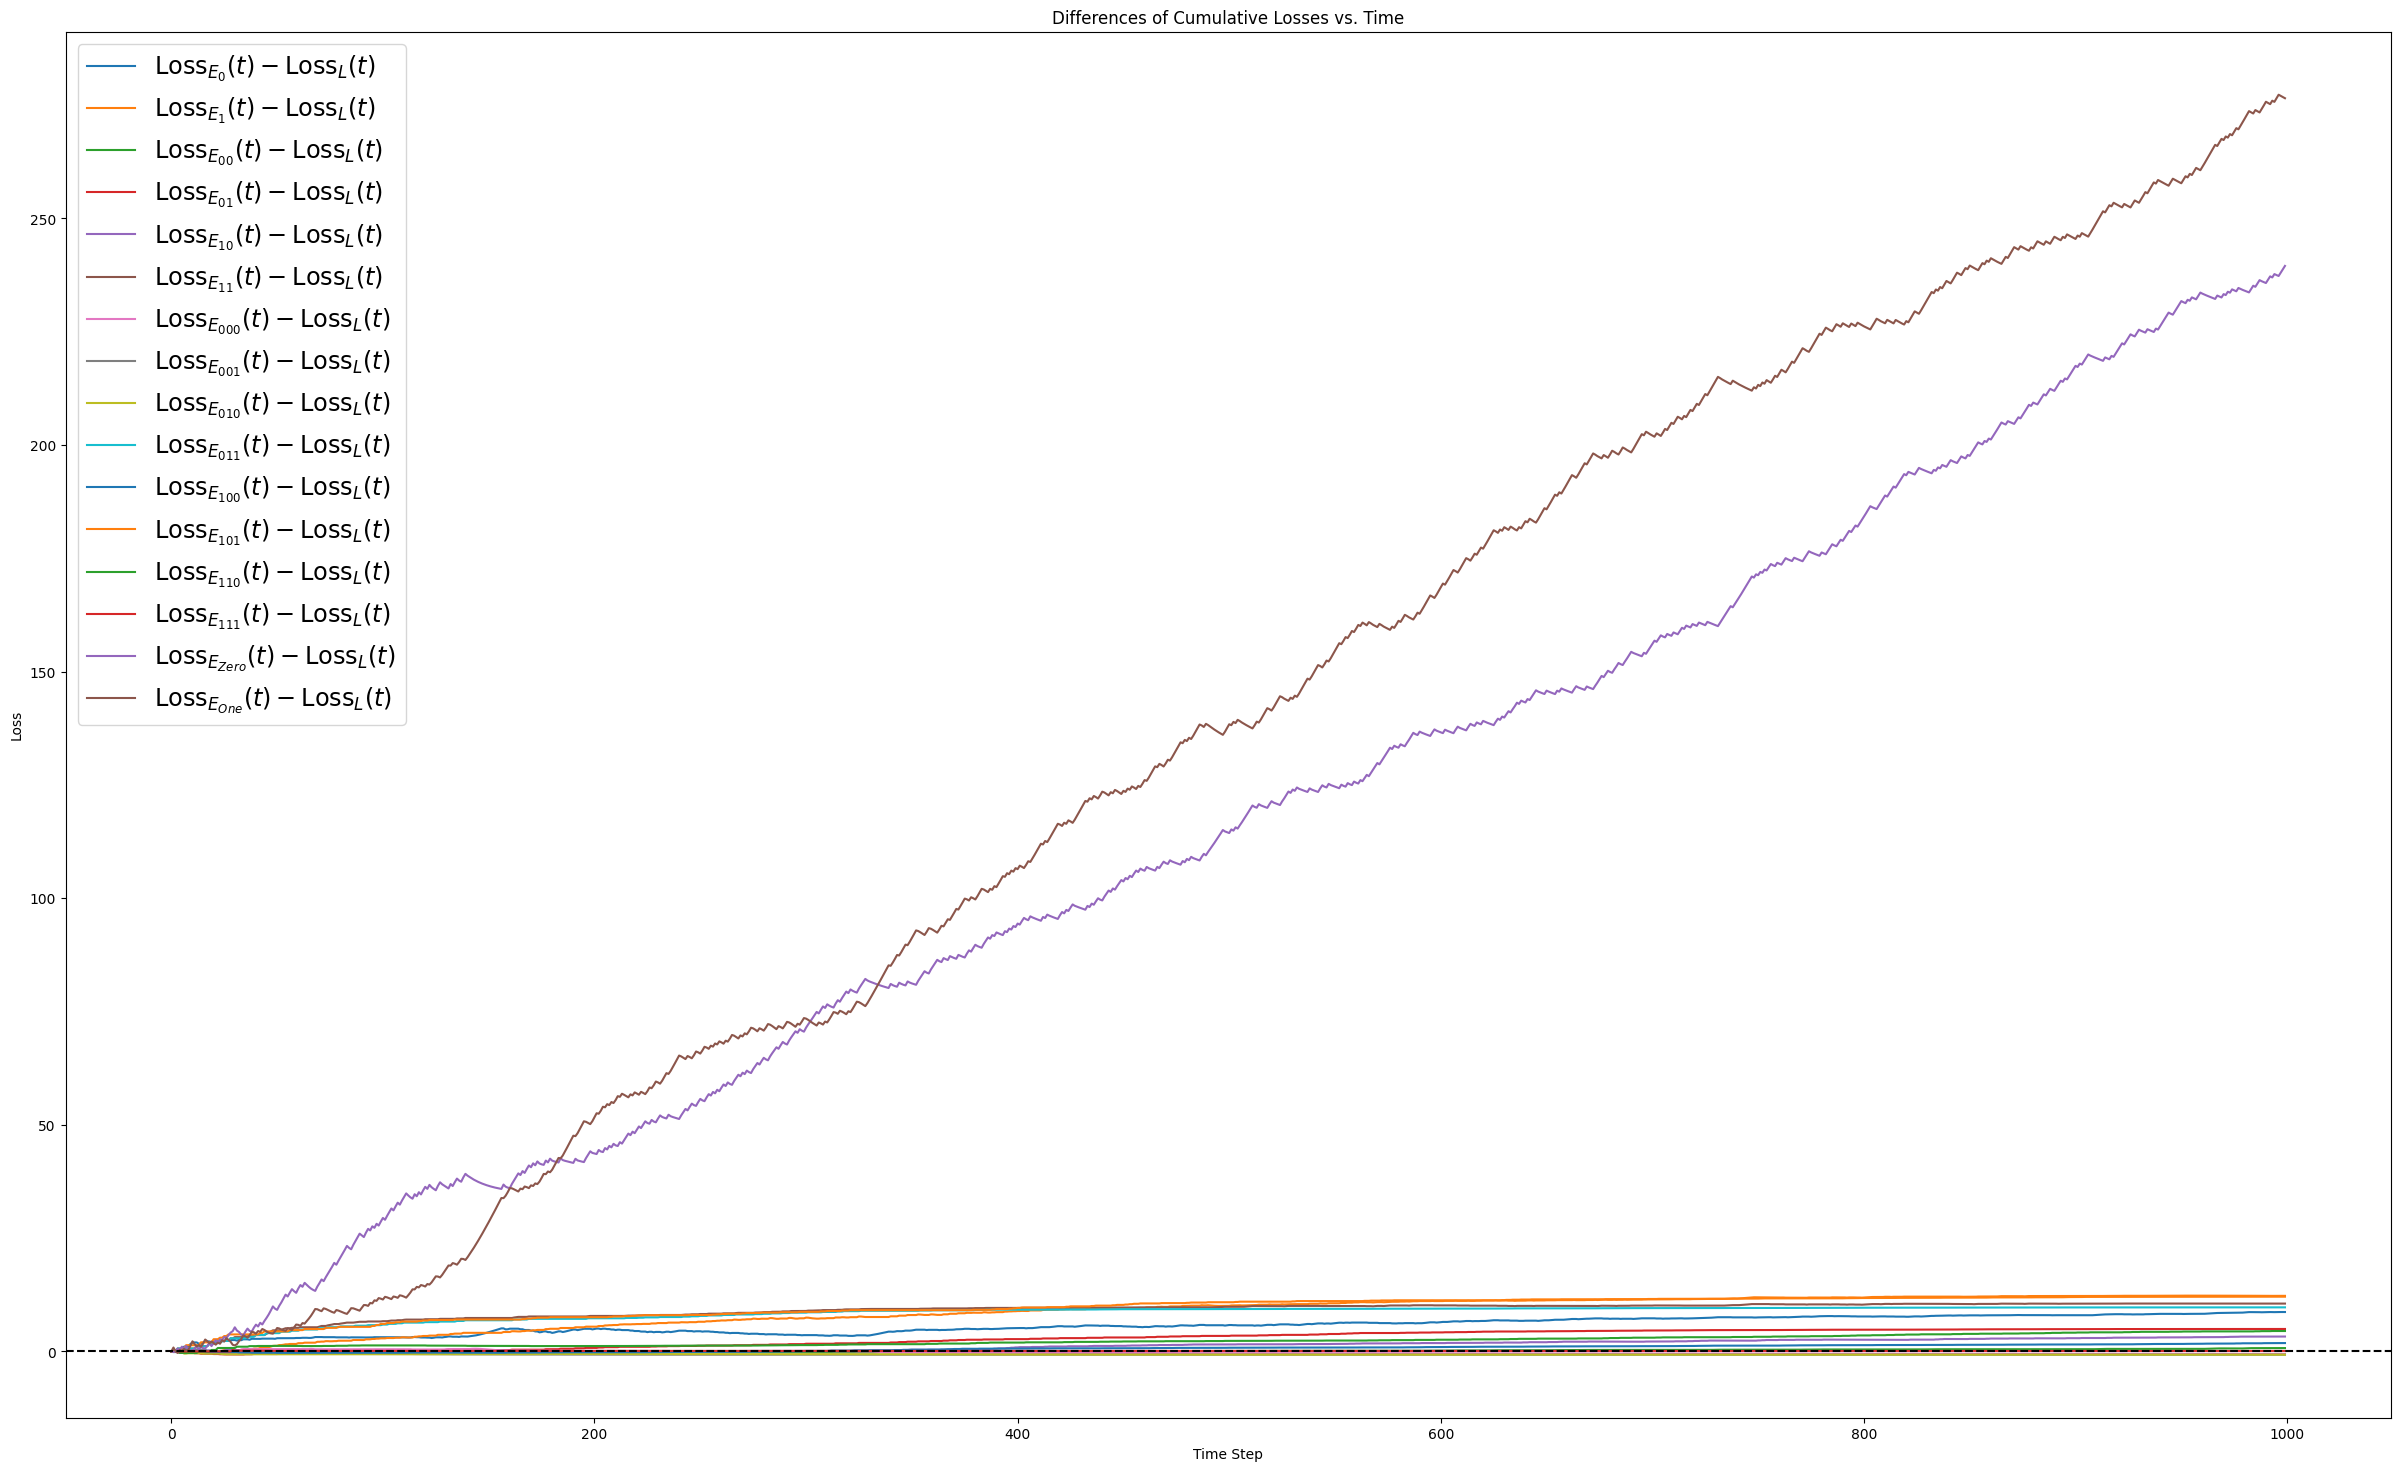

In [171]:
# Experiment #1 - Experts Make Predictions Based on Internal Trackers.

MAX_PREFIX_LENGTH = 2
TEST_SEQUENCE = "0110101000110100110110101011110000110011010111110011110110011010000011101111101111100111100110101011011101101110001010110100011000010110011000000000000000001000111101011010100010100001000000100001110001001010100101110101101100100110001000001110110011001101010110100111010100111011001111011001111010011111101101000110111010001111000000000001000100010000111100111100100100010001101100011101010001010101011001000001010000011010110000001010110011101011101010110100100001011001000001010100001101111111100010101111111001000011000011110101000001000011001000001001001001011011110111110100100111100100000110000100001100001100100100000110101101110100101110000100001010000011000010001111011001110011110000010111101100100100110100100100010000011111101111111110101010110010011000100001110000010011100110111011011111100011110111011110100011000000101010011000110010111100101011111001000110111101001110110011101011110101110000000100101111011100110001000101111100111100101001100000001001010100100000110110001101001110"


class Expert:
    """ """

    def __init__(self, prefix: str):
        self.prefix = prefix
        self.num_zeros = 0
        self.num_ones = 0

    def __str__(self):
        return f'Expert "{self.prefix}" - ({self.num_zeros}, {self.num_ones}) '

    def predict(self):
        if self.num_zeros + self.num_ones == 0:
            return 0
        return self.num_ones / (self.num_zeros + self.num_ones)


def generate_experts(length: int):
    """
    Generate all binary strings up to a given length.

    Parameters:
    - length (int): the maximum length of a binary sequence.

    Returns:
    - list: a list of binary strings corresponding to experts.
    """

    def generate(prefix: str, length: int):
        if length == 0:
            return [Expert(prefix)]
        else:
            return generate(prefix + "0", length - 1) + generate(
                prefix + "1", length - 1
            )

    if length <= 0:
        return []
    else:
        return [
            string for length in range(1, length + 1) for string in generate("", length)
        ]


def get_awake_experts(sequence: str, experts: list[Expert]):
    awake_experts = [False] * len(experts)

    for i, expert in enumerate(experts):
        if (
            sequence.endswith(expert.prefix)
            or expert.prefix == "Zero"
            or expert.prefix == "One"
        ):
            awake_experts[i] = True

    return awake_experts


experts = generate_experts(3)
# Add experts that always predict 0 and 1.
zero_expert = Expert("Zero")
zero_expert.predict = lambda: 0
experts.append(zero_expert)
one_expert = Expert("One")
one_expert.predict = lambda: 1
experts.append(one_expert)


omegas = np.array([int(bit) for bit in TEST_SEQUENCE])
gammas = np.empty((0, len(experts)), dtype=float)
for i in range(1, len(TEST_SEQUENCE)):
    substring = TEST_SEQUENCE[0:i]
    awake_experts = get_awake_experts(substring, experts)
    gammas_t = [float("nan")] * len(experts)
    for j, expert in enumerate(experts):
        if awake_experts[j]:
            gammas_t[j] = expert.predict()
            if TEST_SEQUENCE[i] == "0":
                expert.num_zeros += 1
            else:
                expert.num_ones += 1
    gammas = np.vstack((gammas, gammas_t))

(cumulative_experts_losses, cumulative_learner_loss) = aggregating_algorithm(
    gammas, omegas
)

plt.figure(figsize=(30, 18))
for i in range(len(cumulative_experts_losses[0])):
    plt.plot(
        np.arange(len(gammas) + 1),
        cumulative_experts_losses[:, i] - cumulative_learner_loss,
        label=f"$\\text{{Loss}}_{{E_{{{experts[i].prefix}}}}}(t) - \\text{{Loss}}_L(t)$",
    )
plt.axhline(y=0, color="black", linestyle="--")
plt.title("Differences of Cumulative Losses vs. Time")
plt.xlabel("Time Step")
plt.ylabel("Loss")
plt.legend(fontsize="xx-large")
plt.show()